In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams['figure.figsize'] = 10, 10

%matplotlib inline

In [ ]:
enq_ga = pd.read_csv('../data/enq_data_ga.csv')
enq_dw = pd.read_csv('../data/enq_data_dw.csv')
booking = pd.read_csv('../data/booking_data_dw.csv')

In [ ]:
enq_ga.head(3)
enq_ga_cols = ['Event label', 'Country', 'Date']
enq_ga.Date = pd.to_datetime(enq_ga.Date)

In [ ]:
enq_dw.head(3)
enq_dw_cols = ['website_reference_number', 'created']
enq_dw.created = pd.to_datetime(enq_dw.created)

In [ ]:
booking.head(3)
booking_cols = ['website_reference_number', 'booking_created_DT',
          'invoice_date', 'travel_date', 'ServiceGroupType', 'DESTINATION']
booking.booking_created_DT = pd.to_datetime(booking.booking_created_DT)

In [ ]:
enq_ga.loc[:, 'dummy'] = [1]*len(enq_ga)
enq_ga.set_index('Date', drop=False, inplace=True)

enq_dw.loc[:, 'dummy'] = [1]*len(enq_dw)
enq_dw.set_index('created', drop=False, inplace=True)

booking.loc[:, 'dummy'] = [1]*len(booking)
booking.set_index('booking_created_DT', drop=False, inplace=True)

In [ ]:
dt = enq_ga[enq_ga_cols].merge(enq_dw[enq_dw_cols], how='inner', left_on='Event label',
            right_on='website_reference_number').merge(booking[booking_cols], how='inner',
                                                      left_on='Event label',
                                                      right_on='website_reference_number')

dt.drop('website_reference_number_y', axis=1, inplace=True)
dt.set_index('created', inplace=True, drop=False)
dt.index = pd.to_datetime(dt.index)

# cast dates
dt.created = pd.to_datetime(dt.created)
dt.booking_created_DT = pd.to_datetime(dt.booking_created_DT)
dt.invoice_date = pd.to_datetime(dt.invoice_date)
dt.travel_date = pd.to_datetime(dt.travel_date)

# remove NA Destinations
dt.dropna(axis=0, how='any', inplace=True)
dt.drop_duplicates(subset=['Event label', 'website_reference_number_x',
                          'created', 'DESTINATION'], inplace=True)
dt.loc[:, 'dummy'] = [1]*len(dt)
dt.loc[:, 'day_part'] = [str(date)[:10] for date in dt.index]

dt.head(6)

In [ ]:
countries = ['United States', 'United Kingdom', 'Australia','Canada']
dt_countries = dt[dt.Country.isin(countries)]
# dt_countries = dt.copy()
# dt_countries.loc[:, 'dummy'] = [1]*len(dt_countries)
# dt_countries.loc[:, 'day_part'] = [str(date)[:10] for date in dt_countries.index]

enq_to_book_days = ((dt_countries.booking_created_DT - dt_countries.created).dt.total_seconds()) / (60*60*24.0)
enq_to_book_days[enq_to_book_days < 0] = 0.0  # for days that come out negative

enq_to_travel_days = ((dt_countries.travel_date - dt_countries.created).dt.total_seconds()) / (60*60*24.0)
enq_to_travel_days[enq_to_travel_days < 0] = 0.0

dt_countries['enq_to_book_days'] = enq_to_book_days
dt_countries.loc[:, 'enq_to_travel_days'] = enq_to_travel_days

dt_countries.loc[:, 'month'] = dt_countries.created.dt.month_name()

In [ ]:
countries = ['United States', 'United Kingdom', 'Australia', 'Canada']
a = dt_countries.groupby(['Country', 'day_part'])['dummy'].count().unstack().fillna(value=0).stack()

a = a.reset_index()
a.index = pd.to_datetime(a.day_part)
a.Country = a.Country.astype('category')

fig, ax = plt.subplots()
for country in countries:
    data = a[a.Country == country]
    data.resample('w').sum().plot(ax=ax)

ax.set_ylabel('number of enquiries')
ax.set_xlabel('date')
    
plt.legend(countries);

### Distribution Julien suggest

#### Count of enquiries and the general distribution of e2b times

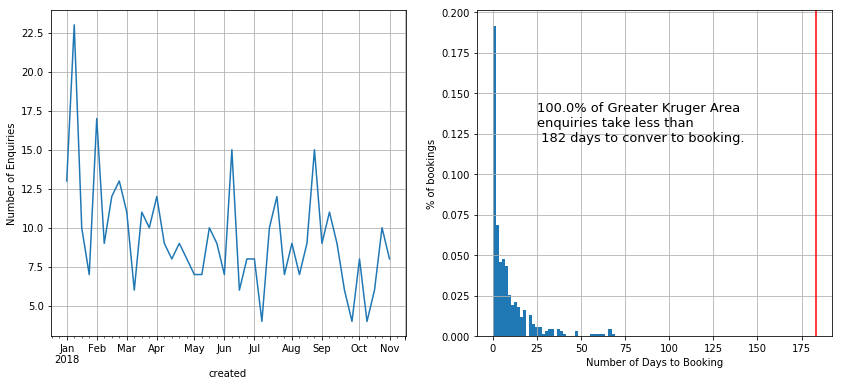

In [38]:
def plot_num_of_enq(destination, bound, data):
    data = data[data.DESTINATION == destination]
    
    fig, ax = plt.subplots(1, 2)
    fig.set_size_inches(14, 6)
    data['dummy'].resample('w').sum().plot(ax=ax[0])
    #data['enq_to_book_days'].resample('w').sum().plot(ax=ax[1])
    data['enq_to_book_days'][data.enq_to_book_days < 70].hist(bins=40, density=True, ax=ax[1])
    #data['enq_to_book_days'][data.enq_to_book_days < 50].plot.kde()
    
    ax0 = ax[0]; ax0.set(ylabel='Number of Enquiries')
    ax0.grid(True)
    ax1 = ax[1]; ax1.set(xlabel='Number of Days to Booking', ylabel='% of bookings')
    
    q = data['enq_to_book_days'].quantile(q=bound)
    ax1.axvline(x=q, color='r')
    ax1.text(25, 0.12, str(bound*100)+'% of ' + str(destination)+ ' \nenquiries take less than\n '\
             +str(int(q)) + ' days to conver to booking.', fontsize=13)
    
from ipywidgets import interact, interactive, fixed
import ipywidgets as widgets

interact(plot_num_of_enq, data=fixed(dt_countries),bound=widgets.FloatSlider(min=0,max=1,step=0.1,value=10),
         destination=dt_countries.DESTINATION.value_counts()[:7].index.tolist());

In [ ]:
def plot_num_of_enq(destination, data):
    data = data[data.DESTINATION == destination]
    
    fig, ax = plt.subplots(1, 2)
    fig.set_size_inches(16, 6)
    data['dummy'].resample('w').sum().plot(ax=ax[0])
    
    data.set_index('booking_created_DT', inplace=True)
    #data['enq_to_book_days'].resample('w').sum().plot(ax=ax[1])
    #data['enq_to_book_days'][data.enq_to_book_days < 70].hist(bins=40, ax=ax[1])
    #data['enq_to_book_days'][data.enq_to_book_days < 50].plot.kde()
    sns.boxplot(x='month', y='enq_to_book_days',  
                 data=dt_countries, ax=ax[1])
    
    ax0 = ax[0]; ax0.set(ylabel='Number of Enquiries')
    ax1 = ax[1]; ax1.set(xlabel='Number of Days to Booking', ylabel='Count')
    ax1.set_ylim(-1, 150)
    
from ipywidgets import interact, interactive, fixed
import ipywidgets as widgets

interact(plot_num_of_enq, data=fixed(dt_countries), destination=dt_countries.DESTINATION.value_counts()[:7].index.tolist());

sns.boxplot(x='month', y='enq_to_book_days',  hue='Country', data=dt_countries, ax=ax);

In [ ]:
dt_countries['enq_to_book_days'].median()

#### Count of Enquiries over enquiry time and Count of bookings over booking times

In [ ]:
def plot_num_of_enq(destination, data):
    data = data[data.DESTINATION == destination]
    
    fig, ax = plt.subplots()
    fig.set_size_inches(14, 7)
    data['dummy'].resample('w').sum().plot(ax=ax)
    ax.set_ylabel('number of enquiries', color='b')
    ax.tick_params('y', colors='b')
    
    ax2 = ax.twinx()
    data.set_index('booking_created_DT', inplace=True)
    data['dummy'].resample('w').sum().plot(ax=ax2, color='r')
    #ax2.set(xlabel='Date', ylabel='number of bookings')
    ax2.set_ylabel('number of bookings', color='r')
    ax2.tick_params('y', colors='r')
    ax2.tick_params('y', colors='r')
    
    ax.grid(True)
    
from ipywidgets import interact, interactive, fixed
import ipywidgets as widgets

interact(plot_num_of_enq, data=fixed(dt_countries), destination=dt_countries.DESTINATION.value_counts()[:7].index.tolist());

### Time to book

In [ ]:
enq_to_book_days = ((dt_countries.booking_created_DT - dt_countries.created).dt.total_seconds()) / (60*60*24.0)
enq_to_book_days[enq_to_book_days < 0] = 0.0  # for days that come out negative

enq_to_travel_days = ((dt_countries.travel_date - dt_countries.created).dt.total_seconds()) / (60*60*24.0)
enq_to_travel_days[enq_to_travel_days < 0] = 0.0

dt_countries.loc[:, 'enq_to_book_days'] = enq_to_book_days
dt_countries.loc[:, 'enq_to_travel_days'] = enq_to_travel_days

dt_countries.loc[:, 'month'] = dt_countries.created.dt.month_name();

In [ ]:
fig, ax = plt.subplots()
fig.set_size_inches(10,7)
ax.set_ylim(-1, 70)
sns.boxplot(x='month', y='enq_to_book_days',  hue='Country', data=dt_countries, ax=ax);

### TIme to travel

In [ ]:
fig, ax = plt.subplots()
fig.set_size_inches(10,7)
#ax.set_ylim(-1, 70)
sns.boxplot(x='month', y='enq_to_travel_days',  hue='Country', data=dt_countries, ax=ax);

In [ ]:
def plot_dist(destination, data=dt_countries):
    dt = dt_countries[dt_countries.DESTINATION == destination]
    
    fig, ax = plt.subplots()
    fig.set_size_inches(10,7)
    
    sns.boxplot(x='month', y='enq_to_book_days',  
                data=dt, ax=ax)

    

from ipywidgets import interact, interactive, fixed
import ipywidgets as widgets

interact(plot_dist, data=fixed(dt_countries), destination=dt_countries.DESTINATION.value_counts()[:7].index.tolist());
    


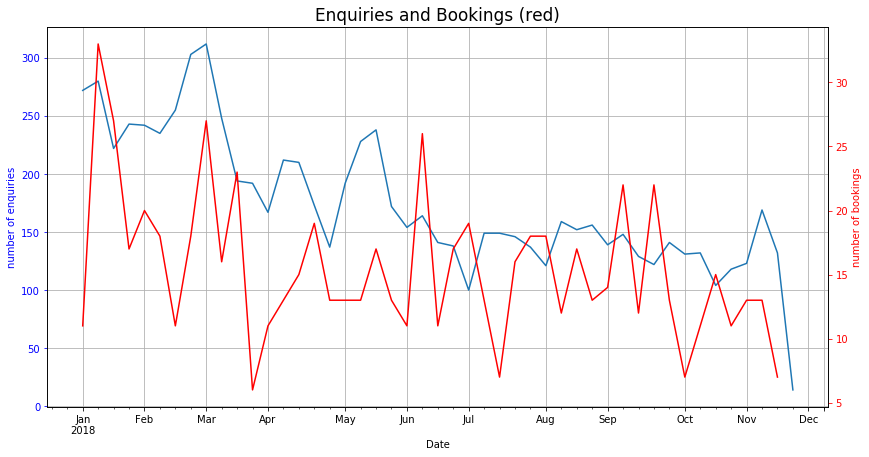

In [41]:
def plot_enq_book(destination, enq_ga=enq_ga, enq_dw=enq_dw, booking=booking):
    booking = booking[booking.DESTINATION == destination]
    
    
    fig, ax = plt.subplots()
    fig.set_size_inches(14, 7)
    enq_ga['dummy'].resample('w').sum().plot(ax=ax)
    ax.set_ylabel('number of enquiries', color='b')
    ax.tick_params('y', colors='b')
    
    ax2 = ax.twinx()
    #data.set_index('booking_created_DT', inplace=True)
    booking['dummy'].resample('w').sum().plot(ax=ax2, color='r')
    #ax2.set(xlabel='Date', ylabel='number of bookings')
    ax2.set_ylabel('number of bookings', color='r')
    ax2.tick_params('y', colors='r')
    ax2.tick_params('y', colors='r')
    
    ax.grid(True); ax.set_title('Enquiries and Bookings (red)', fontsize=17)
    ax.set
    
from ipywidgets import interact, interactive, fixed
import ipywidgets as widgets

interact(plot_enq_book, enq_ga=fixed(enq_ga), enq_dw=fixed(enq_dw), booking=fixed(booking),
         destination=booking.DESTINATION.value_counts()[:7].index.tolist());